# [TabPFN](https://github.com/PriorLabs/TabPFN): Binary classification using the [Bank Marketing Dataset](https://www.kaggle.com/datasets/sushant097/bank-marketing-dataset-full)
Written by [Carl McBride Ellis](https://www.linkedin.com/in/carl-mcbride-ellis/) for **[Prior Labs](https://priorlabs.ai/)** <br>
Dataset credit: [Sushant Gautam](https://www.kaggle.com/sushant097) <br>

### Introduction
In this first webinar (YouTube video: **[TabPFN in Action: a Practical Workshop](https://www.youtube.com/watch?v=3hTm1I1vig0)**) we shall see how simple it is to use the most basic 'vanilla' version of TabPFN. We shall perform a classification task on
a dataset that was used as the basis of the recent Kaggle [Binary Classification with a Bank Dataset](https://www.kaggle.com/competitions/playground-series-s5e8/data) competition. We shall compare side-by-side our results with those of the default CatBoost classifier.

The user defined helper functions are hidden just below; click to show the hidden code.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 36)
pd.set_option("display.max_colwidth", 72)

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (16, 5)
plt.style.use('fivethirtyeight')
mono_font = {'fontname':'monospace'}

import seaborn as sns
sns.set(font_scale=1.2)

#-------------------------------------------------------
# source: https://gist.github.com/Carl-McBride-Ellis/74ecb851fa06502c17cf14e8af8c08c6

def undersample_df(df, target, seed=42):
    """Undersample a (binary class) pandas dataframe (df), shuffle, and return X and y"""
    label, count = np.unique(df[target], return_counts=True)
    most_frequent_class = label[np.argmax(count)]
    # sample ALL of the minority class data
    df_class_1 = df.loc[df[target] != most_frequent_class]
    # randomly sample the majority class data
    df_class_0 = df.loc[df[target] == most_frequent_class].sample(n = len(df_class_1), random_state=seed)
    # now randomly shuffle this new dataset
    X = pd.concat([df_class_0, df_class_1]).sample(frac=1, random_state=seed).reset_index(drop=True)
    y = X.pop(target)
    
    return X, y
    
#-------------------------------------------------------
# source: https://gist.github.com/Carl-McBride-Ellis/96d7bceed6bb42918152fa79f59b8be4

def BCAS(y_validation, y_pred):
    """Baseline corrected accuracy score (BCAS).
       y_validation: contains the ground truth labels
       y_pred: contains the predicted labels
    """
    label, count = np.unique(y_validation, return_counts=True)
    most_frequent_class = label[np.argmax(count)]
    y_baseline = np.full(len(y_validation), most_frequent_class)
    as_baseline = np.mean(y_validation == y_baseline)
    as_predicted = np.mean(y_validation == y_pred)

    return (as_predicted - as_baseline)

#-------------------------------------------------------

from sklearn.model_selection import StratifiedKFold
def cross_validation(X, y, estimator, n=5, seed=42):

    kf = StratifiedKFold(n_splits=n, shuffle=True, random_state=seed)
    OOF_predictions = [] # save predictions for each fold
    OOF_probabilities = [] # save probabilities for each fold

    for train_index, validation_index in kf.split(X, y):

        X_train = X.iloc[train_index]
        X_validation = X.iloc[validation_index]

        y_train = y.iloc[train_index]
        y_validation = y.iloc[validation_index]

        # fit
        estimator.fit(X_train, y_train)

        # predict
        y_pred = estimator.predict(X_validation)
        y_pred_proba = estimator.predict_proba(X_validation)[:,1]

        # save the predictions for this fold
        preds_df = pd.DataFrame(validation_index, columns=["idx"])
        preds_df["y_pred"] = y_pred
        OOF_predictions.append( preds_df )

        probs_df = pd.DataFrame(validation_index, columns=["idx"])
        probs_df["y_pred_proba"] = y_pred_proba
        OOF_probabilities.append( probs_df )
    
    # stitch all the OOF predictions together
    df_y_pred = pd.concat(OOF_predictions).sort_values(by=["idx"]).set_index("idx")
    df_y_prob = pd.concat(OOF_probabilities).sort_values(by=["idx"]).set_index("idx")

    return df_y_pred, df_y_prob

#-------------------------------------------------------

# classification metrics we shall use
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score

def classifier_report(y, y_pred, y_pred_proba, decimals = 4):
    
    y_baseline = np.zeros( len(y) ) # assume majority class is 0
    BAS = accuracy_score(y, y_baseline)
    y_train_mean = np.full( len(y), np.mean(y) )
    log_loss_baseline = log_loss(y, y_train_mean)
    Brier_score_baseline = brier_score_loss(y, y_train_mean)
    #---------------------------------------------------------
    CV_score_accuracy = accuracy_score(y, y_pred)
    CV_score_matthews_corrcoef = matthews_corrcoef(y, y_pred)
    score_BCAS = BCAS(y.values, y_pred.values.reshape(-1))
    
    CV_score_brier_score = brier_score_loss(y, y_pred_proba)
    CV_score_log_loss = log_loss(y, y_pred_proba)
    CV_score_roc_auc_score = roc_auc_score(y, y_pred_proba)
    
    print("Baseline accuracy score           ", round( BAS , decimals) )
    print("Baseline ROC AUC score             0.5")
    print("Baseline Matthews correlation      0")
    print("Baseline log loss                 ", round( log_loss_baseline , decimals) )
    print("Baseline Brier score              ", round( Brier_score_baseline , decimals) )
    print("----------------------------------")
    print("Accuracy score                    ", round( CV_score_accuracy , decimals) )
    print("Baseline corrected accuracy score ", round( score_BCAS , decimals) )
    print("Matthews correlation              ", round( CV_score_matthews_corrcoef , decimals) )
    print("ROC AUC score                     ", round( CV_score_roc_auc_score , decimals) )
    print()
    print("Note: For both log loss and the Brier the score the smaller the better:")
    print()
    print("Log loss                          ", round( CV_score_log_loss , decimals) )
    print("Brier score                       ", round( CV_score_brier_score , decimals) )
    print()
    print("Confusion matrix:")
    tn, fp, fn, tp = confusion_matrix(y , y_pred).ravel()
    #print("TN",tn,"\nFP",fp,"\nFN",fn,"\nTP",tp)
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots(figsize=(3,3))
    sns.heatmap(cm, cmap="YlOrBr", annot=True, fmt="g", linewidths=1, linecolor='black')
    ax.set(xlabel='Predicted label', ylabel='True label');
    print()
    
    return 

Read in and take a look at the dataset

In [2]:
df = pd.read_csv("/kaggle/input/bank-marketing-dataset-full/bank-full.csv", delimiter=";")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
target = "y"

print(df[target].value_counts(normalize=False))
print(df[target].value_counts(normalize=True))

y
no     39922
yes     5289
Name: count, dtype: int64
y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


Binarize the target to facilitate the metrics calculations

In [4]:
df[target] = df[target].map({"no":0,"yes":1})

Both TabPFN and CatBoost have native support for `NaN`.

In [5]:
df.isna().sum().sum()

0

We see here that on this occasion we do not have any `NaN`.

We shall quickly inspect the categorical features. Note that neither TabPFN nor CatBoost have a need for any categorical encoding of the features. 

In [6]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [7]:
cat_features = list(df.select_dtypes(['object']).columns) # for CatBoost

for cat_feature in cat_features:
    print(df[cat_feature].value_counts())
    print("-----------------")

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64
-----------------
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64
-----------------
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64
-----------------
default
no     44396
yes      815
Name: count, dtype: int64
-----------------
housing
yes    25130
no     20081
Name: count, dtype: int64
-----------------
loan
no     37967
yes     7244
Name: count, dtype: int64
-----------------
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64
-----------------
month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oc

For this exercise we shall use a balanced dataset obtained via undersampling of the majority class, and we shall 
then set aside 2K rows of the data for a later inspection of how well the models are calibrated

In [8]:
X, y = undersample_df( df, target )

from sklearn.model_selection import train_test_split
X, X_calibration, y, y_calibration = train_test_split(X, y, test_size=2000, random_state=42, stratify=y)

print(X.shape)
print(y.value_counts())

(8578, 16)
y
0    4289
1    4289
Name: count, dtype: int64


# Comparison between CatBoost and TabPFN
### CatBoost

In [9]:
# display the version we are using
!pip freeze | grep catboost

catboost==1.2.8


Baseline accuracy score            0.5
Baseline ROC AUC score             0.5
Baseline Matthews correlation      0
Baseline log loss                  0.6931
Baseline Brier score               0.25
----------------------------------
Accuracy score                     0.8656
Baseline corrected accuracy score  0.3656
Matthews correlation               0.7326
ROC AUC score                      0.9301

Note: For both log loss and the Brier the score the smaller the better:

Log loss                           0.325
Brier score                        0.0997

Confusion matrix:



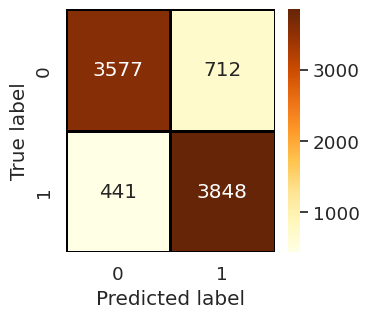

In [10]:
from catboost import CatBoostClassifier

CatBoostClassifier = CatBoostClassifier(silent=True, cat_features=cat_features)

CatBoost_pred, CatBoost_prob = cross_validation(X, y, CatBoostClassifier)

classifier_report(y, CatBoost_pred, CatBoost_prob)

### TabPFN

In [11]:
!uv pip install -q tabpfn
# display the version we are using
!pip freeze | grep tabpfn

tabpfn==2.2.1
tabpfn-common-utils==0.2.2


tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Baseline accuracy score            0.5
Baseline ROC AUC score             0.5
Baseline Matthews correlation      0
Baseline log loss                  0.6931
Baseline Brier score               0.25
----------------------------------
Accuracy score                     0.8729
Baseline corrected accuracy score  0.3729
Matthews correlation               0.7487
ROC AUC score                      0.9349

Note: For both log loss and the Brier the score the smaller the better:

Log loss                           0.3079
Brier score                        0.0937

Confusion matrix:



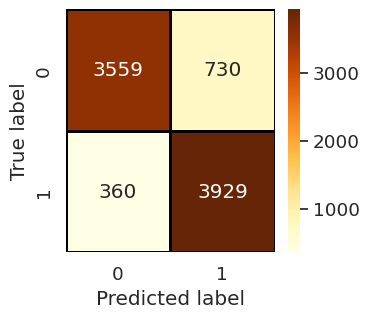

In [12]:
from tabpfn import TabPFNClassifier

TabPFNClassifier = TabPFNClassifier()

TabPFN_pred, TabPFN_prob = cross_validation(X, y, TabPFNClassifier)

classifier_report(y, TabPFN_pred, TabPFN_prob)

We can see that, for each of the metrics, the "vanilla" TabPFN estimator outperforms the default CatBoost classifier, both for probabilistic metrics as was as the for the dichotomized classification metrics.
# Vizualizations of the results
### ROC curve

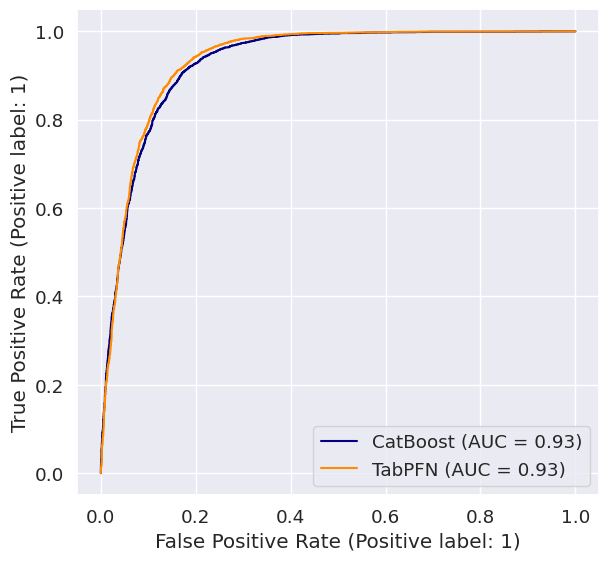

In [13]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(y, CatBoost_prob, color="navy", ax=ax, name="CatBoost");
RocCurveDisplay.from_predictions(y, TabPFN_prob, color="darkorange", ax=ax, name="TabPFN");

We see that the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for TabPFN appears to be slightly superior to that of CatBoost.
### Histograms of the probabilities
The full range between 0 and 1

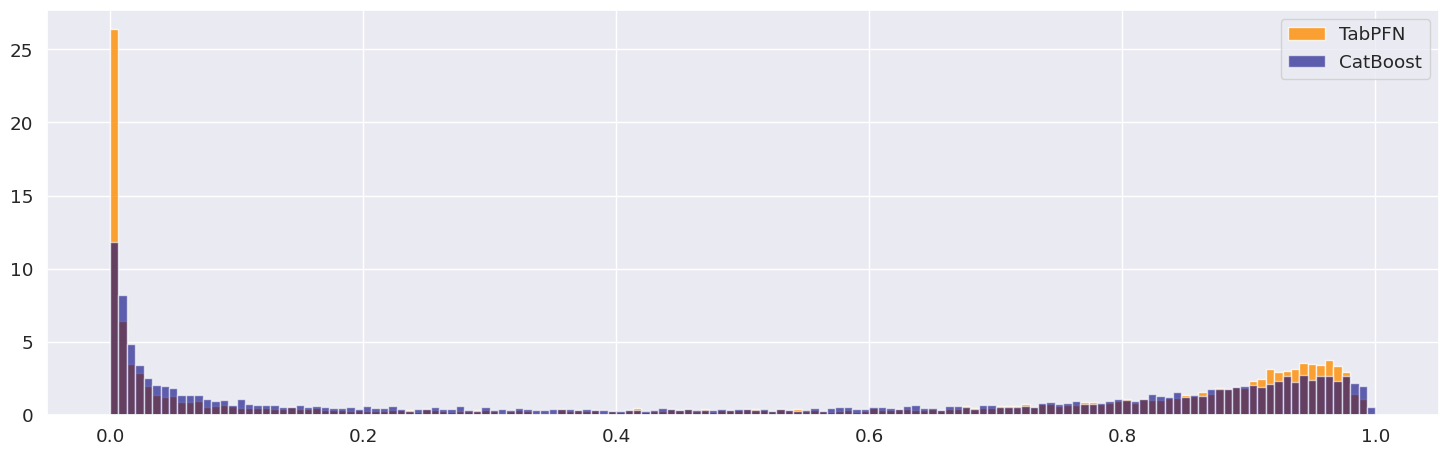

In [14]:
fig, ax1 = plt.subplots()
ax1.hist(TabPFN_prob,   range=[0,1], bins=150, density=True, color="darkorange", alpha=0.8, label="TabPFN")
ax1.hist(CatBoost_prob, range=[0,1], bins=150, density=True, color="navy", alpha=0.6, label="CatBoost")
plt.legend(loc='best')
plt.show();

and here we shall zoom in on the range between $p=0$ and $p=0.02$.

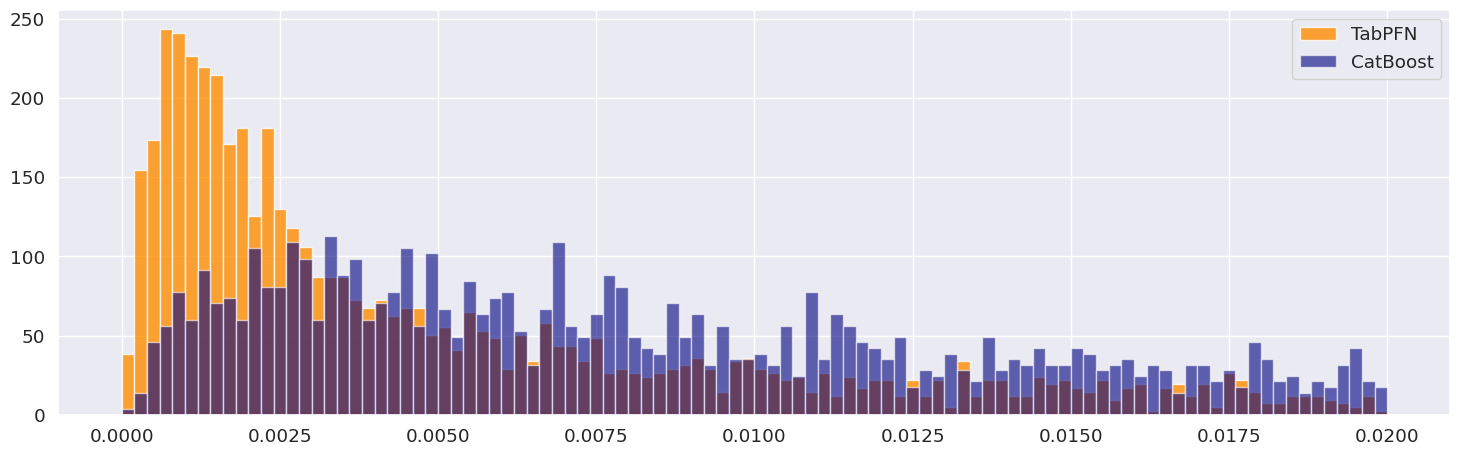

In [15]:
fig, ax1 = plt.subplots()
ax1.hist(TabPFN_prob,   range=[0, 0.02], bins=100, density=True, color="darkorange", alpha=0.8, label="TabPFN")
ax1.hist(CatBoost_prob, range=[0, 0.02], bins=100, density=True, color="navy", alpha=0.6, label="CatBoost")
plt.legend(loc='best')
plt.show();

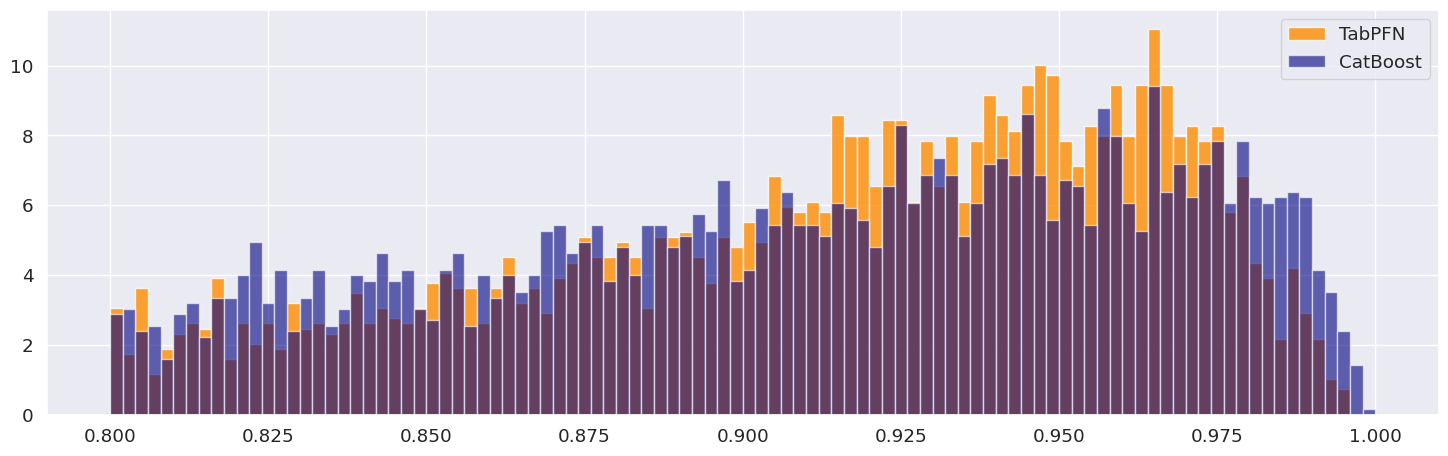

In [16]:
fig, ax1 = plt.subplots()
ax1.hist(TabPFN_prob,   range=[0.8, 1], bins=100, density=True, color="darkorange", alpha=0.8, label="TabPFN")
ax1.hist(CatBoost_prob, range=[0.8, 1], bins=100, density=True, color="navy", alpha=0.6, label="CatBoost")
plt.legend(loc='best')
plt.show();

We observe that perhaps the greatest difference is seen for probabilities approaching zero; TabPFN is much more confident about the negative class predictions.

### Calibration
Let us now look at how well the [predictions are calibrated](https://scikit-learn.org/stable/modules/calibration.html)

In [17]:
CatBoost_full_model = CatBoostClassifier.fit(X, y) # full fit
CatBoost_prob_full = CatBoost_full_model.predict_proba(X_calibration)[:,1]

In [18]:
TabPFN_full_model = TabPFNClassifier.fit(X, y) # full fit
TabPFN_prob_full = TabPFN_full_model.predict_proba(X_calibration)[:,1]

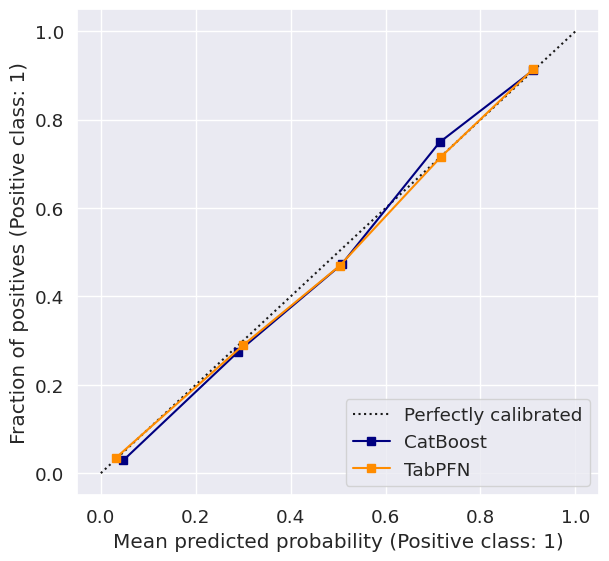

In [19]:
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots(figsize=(6, 6))
CalibrationDisplay.from_predictions(y_calibration, CatBoost_prob_full, color="navy", ax=ax, name="CatBoost", n_bins=5);
CalibrationDisplay.from_predictions(y_calibration, TabPFN_prob_full, color="darkorange", ax=ax, name="TabPFN", n_bins=5);

We can see that both classifiers return fairly well calibrated probabilities out-of-the-box, although *post hoc* calibration is never a bad idea.
# TabPFN related links
* [Noah Hollmann, Samuel Müller, Lennart Purucker, Arjun Krishnakumar, Max Körfer, Shi Bin Hoo, Robin Tibor Schirrmeister, and Frank Hutter *"Accurate predictions on small data with a tabular foundation model"*, Nature **637** 319-326 (2025)](https://doi.org/10.1038/s41586-024-08328-6)
* [Noah Hollmann, Samuel Müller, Katharina Eggensperger, Frank Hutter *"TabPFN: A Transformer That Solves Small Tabular Classification Problems in a Second"*, arXiv:2207.01848 (2022)](https://arxiv.org/pdf/2207.01848)
* [TabPFN on GitHub](https://github.com/PriorLabs/TabPFN)